In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

Formatting The Data

In [23]:
df = pd.read_csv("loan_data_ex.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High School,12438,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1


In [24]:
df['person_education'] = df['person_education'].replace(' ','_',regex=True)
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High_School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High_School,12438,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1


In [25]:
df.dtypes

person_age                          int64
person_gender                      object
person_education                   object
person_income                       int64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                           int64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length          int64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [26]:
inputs = df.drop('loan_status',axis=1).copy()
inputs.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No
1,21,female,High_School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes
2,25,female,High_School,12438,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No


In [27]:
output = df['loan_status'].copy()
output.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [28]:
inputs_encoded = pd.get_dummies(inputs, columns=['person_gender',
                                       'person_education',
                                       'person_home_ownership',
                                       'loan_intent',
                                       'previous_loan_defaults_on_file'],dtype=int)
inputs_encoded.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_female,person_gender_male,person_education_Associate,person_education_Bachelor,person_education_High_School,person_education_Master,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,22,71948,0,35000,16.02,0.49,3,561,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0
1,21,12282,0,1000,11.14,0.08,2,504,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
2,25,12438,3,5500,12.87,0.44,3,635,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
3,23,79753,0,35000,15.23,0.44,2,675,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0
4,24,66135,1,35000,14.27,0.53,4,586,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0


In [29]:
output.unique()

array([1, 0])

Now Building The Actual ML Model

In [30]:
sum(output)/len(output)

0.8

In [31]:
#24.5% of people got loans

In [32]:
df = pd.read_csv("loan_data_ex.csv")
print(df.shape)
print(df['loan_status'].value_counts())


(10, 14)
loan_status
1    8
0    2
Name: count, dtype: int64


In [33]:
inputs_train, inputs_test, output_train, output_test = train_test_split(inputs_encoded, output, random_state = 0, stratify = output)

In [34]:
sum(output_train)/len(output_train)

0.8571428571428571

In [35]:
sum(output_test)/len(output_test)

0.6666666666666666

In [36]:
datatrain = xgb.DMatrix(inputs_train, label=output_train)
datatest = xgb.DMatrix(inputs_test, label=output_test)

parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'seed': 0
}

model = xgb.train(parameters,datatrain,num_boost_round=1000,evals=[(datatest, 'eval')],early_stopping_rounds=10,verbose_eval=True)

[0]	eval-aucpr:0.66667
[1]	eval-aucpr:0.66667
[2]	eval-aucpr:0.66667
[3]	eval-aucpr:0.66667
[4]	eval-aucpr:0.66667
[5]	eval-aucpr:0.66667
[6]	eval-aucpr:0.66667
[7]	eval-aucpr:0.66667
[8]	eval-aucpr:0.66667
[9]	eval-aucpr:0.66667


In [37]:
output_probability = model.predict(datatest)
output_prediction = np.where(output_probability >= 0.5, 1, 0)
output_prediction

array([1, 1, 1])

Plotting Data To Show Potential Mistakes

Confusion Matrix Interpretation Sheet: 

Top-left: True Negatives - Model Denies and Actual Denies

Top-right: False Positives - Model Approves and Actual Denies

Bottom-left: False Negatives - Model Denies and Actual Approves

Bottom-right: True Positives - Model Approves and Actual Approves

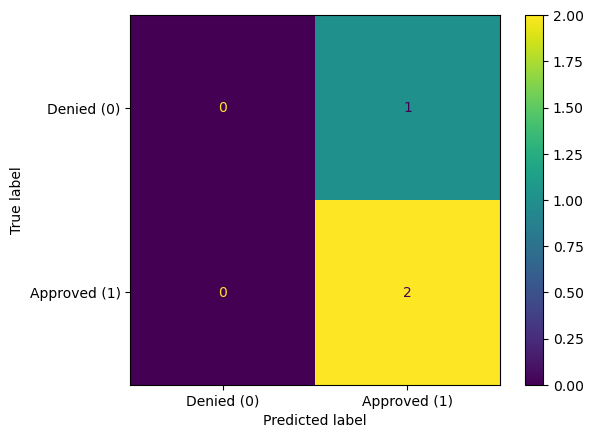

In [38]:
conf_matr = confusion_matrix(output_test, output_prediction)
ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["Denied (0)", "Approved (1)"]).plot()

In [ ]:
# Precision: Shows of all loans model predicted as approved, how many were actually approved
# Recall: Which loans were actually approved and which did the model correctly predict? 
# f1-score: Mean between precision and recall
# Accuracy: Percentage of all loan predictions that the model got correct 

print (classification_report(output_test, output_prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
